In [232]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
import scipy.stats as stats
import pickle
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import ccf, grangercausalitytests
from statsmodels.tsa.api import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore', ConvergenceWarning)

In [233]:
palette_tab10 = sns.color_palette("tab10", 10)
cmap = sns.color_palette([palette_tab10[0], palette_tab10[1]], as_cmap=True)
cmap

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725)]

Read the data

In [234]:
DIR_SUBJECT_1 = '../udataset/meat/production.csv'
# DIR_SUBJECT_1 = '../udataset/meat/cold_storage.csv'
# DIR_SUBJECT_1 = '../udataset/meat/slaughter.csv'
# DIR_SUBJECT_1 = '../udataset/meat/weights.csv'
df_subject1 = pd.read_csv(DIR_SUBJECT_1)
df_subject1

,DateTime,Beef,Veal,Pork,Lamb and Mutton,Broiler,Other Chicken,Turkey,Red Meat,Poultry
0,1921-01,3.580000e+08,27000000.0,5.650000e+08,44000000.0,NaN,NaN,393000000.0,9.940000e+08,3.930000e+08
1,1921-02,2.790000e+08,24000000.0,4.840000e+08,39000000.0,NaN,NaN,NaN,8.260000e+08,0.000000e+00
2,1921-03,3.400000e+08,31000000.0,3.720000e+08,45000000.0,NaN,NaN,NaN,7.880000e+08,0.000000e+00
3,1921-04,3.160000e+08,29000000.0,3.740000e+08,41000000.0,NaN,NaN,NaN,7.600000e+08,0.000000e+00
4,1921-05,3.190000e+08,31000000.0,3.960000e+08,37000000.0,NaN,NaN,NaN,7.830000e+08,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...
1207,2023-08,2.329500e+09,4100000.0,2.282400e+09,8900000.0,4.156700e+09,51100000.0,433500000.0,4.624900e+09,4.641300e+09
1208,2023-09,2.114600e+09,3500000.0,2.175500e+09,8600000.0,3.805500e+09,48400000.0,489200000.0,4.302200e+09,4.343100e+09
1209,2023-10,2.300800e+09,4000000.0,2.406200e+09,9800000.0,4.177300e+09,50600000.0,431200000.0,4.720800e+09,4.659100e+09
1210,2023-11,2.247300e+09,4100000.0,2.377400e+09,10100000.0,3.817300e+09,44500000.0,500300000.0,4.638900e+09,4.362100e+09


In [235]:
# DIR_SUBJECT_2 = '../udataset/unemployment_month_US.csv'
# DIR_SUBJECT_2 = '../dataset/youth_unemployment_rate.csv'
DIR_SUBJECT_2 = '../dataset/national_hourly_earnings.csv'
df_subject2 = pd.read_csv(DIR_SUBJECT_2)
df_subject2

,YearMonth,HourlyEarnings
0,2006-03,20.07
1,2006-04,20.36
2,2006-05,20.06
3,2006-06,20.04
4,2006-07,20.28
...,...,...
212,2023-11,34.08
213,2023-12,34.26
214,2024-01,34.67
215,2024-02,34.61


Make variables for specific dataset 1

In [236]:
# For meat production
df_subject1 = df_subject1.drop(columns=['Other Chicken'])
df_subject1 = df_subject1.dropna()
MEAT_TYPE = ['beef', 'veal', 'pork', 'lamb_and_mutton', 'broiler', 'turkey', 'red_meat', 'poultry']
SUBJECT1 = 'meat_production'
UNIT = 'Pounds'

# For meat cold storage
# MEAT_TYPE = ['beef', 'veal', 'pork', 'lamb_and_mutton', 'broiler', 'turkey', 'frozen_egg', 'red_meat', 'poultry']

SUBJECT_TITLE1 = SUBJECT1.replace('_', ' ').title()
df_subject1

,DateTime,Beef,Veal,Pork,Lamb and Mutton,Broiler,Turkey,Red Meat,Poultry
648,1977-01,1.976000e+09,50000000.0,9.770000e+08,28000000.0,7.138000e+08,146500000.0,3.031000e+09,8.603000e+08
649,1977-02,1.847000e+09,47000000.0,9.680000e+08,26000000.0,6.592000e+08,70500000.0,2.888000e+09,7.297000e+08
650,1977-03,2.041000e+09,53000000.0,1.206000e+09,33000000.0,7.832000e+08,58700000.0,3.333000e+09,8.419000e+08
651,1977-04,1.856000e+09,44000000.0,1.077000e+09,30000000.0,7.449000e+08,80300000.0,3.007000e+09,8.252000e+08
652,1977-05,1.864000e+09,43000000.0,1.003000e+09,25000000.0,8.099000e+08,78900000.0,2.935000e+09,8.888000e+08
...,...,...,...,...,...,...,...,...,...
1207,2023-08,2.329500e+09,4100000.0,2.282400e+09,8900000.0,4.156700e+09,433500000.0,4.624900e+09,4.641300e+09
1208,2023-09,2.114600e+09,3500000.0,2.175500e+09,8600000.0,3.805500e+09,489200000.0,4.302200e+09,4.343100e+09
1209,2023-10,2.300800e+09,4000000.0,2.406200e+09,9800000.0,4.177300e+09,431200000.0,4.720800e+09,4.659100e+09
1210,2023-11,2.247300e+09,4100000.0,2.377400e+09,10100000.0,3.817300e+09,500300000.0,4.638900e+09,4.362100e+09


Make variables for specific dataset 2

In [237]:
# # For unemployment_month_US.csv
# df_subject2 = df_subject2.rename(columns={'Year-Month': 'datetime'})
# SUBJECT2 = 'unemployment_rate'

# # For youth_unemployment_rate.csv
# df_subject2 = df_subject2.rename(columns={'YearMonth': 'datetime', 'UnemploymentRate': 'unemployment_rate'})
# SUBJECT2 = 'unemployment_rate'

# For national_hourly_earnings.csv
df_subject2 = df_subject2.rename(columns={'YearMonth': 'datetime', 'HourlyEarnings': 'hourly_earnings'})
SUBJECT2 = 'hourly_earnings'

SUBJECT_TITLE2 = SUBJECT2.replace('_', ' ').title()
df_subject2

,datetime,hourly_earnings
0,2006-03,20.07
1,2006-04,20.36
2,2006-05,20.06
3,2006-06,20.04
4,2006-07,20.28
...,...,...
212,2023-11,34.08
213,2023-12,34.26
214,2024-01,34.67
215,2024-02,34.61


Change label format to be lower + underscores instead of space

In [238]:
df_subject1.columns = df_subject1.columns.str.lower().str.replace(' ', '_')
df_subject2.columns = df_subject2.columns.str.lower().str.replace(' ', '_')

Change date format to better use together

In [239]:
df_subject1['datetime'] = pd.to_datetime(df_subject1['datetime'])
df_subject2['datetime'] = pd.to_datetime(df_subject2['datetime'])
df_subject2

,datetime,hourly_earnings
0,2006-03-01,20.07
1,2006-04-01,20.36
2,2006-05-01,20.06
3,2006-06-01,20.04
4,2006-07-01,20.28
...,...,...
212,2023-11-01,34.08
213,2023-12-01,34.26
214,2024-01-01,34.67
215,2024-02-01,34.61


In [240]:
df_subject1.reset_index(drop=True, inplace=True)
df_subject1

,datetime,beef,veal,pork,lamb_and_mutton,broiler,turkey,red_meat,poultry
0,1977-01-01,1.976000e+09,50000000.0,9.770000e+08,28000000.0,7.138000e+08,146500000.0,3.031000e+09,8.603000e+08
1,1977-02-01,1.847000e+09,47000000.0,9.680000e+08,26000000.0,6.592000e+08,70500000.0,2.888000e+09,7.297000e+08
2,1977-03-01,2.041000e+09,53000000.0,1.206000e+09,33000000.0,7.832000e+08,58700000.0,3.333000e+09,8.419000e+08
3,1977-04-01,1.856000e+09,44000000.0,1.077000e+09,30000000.0,7.449000e+08,80300000.0,3.007000e+09,8.252000e+08
4,1977-05-01,1.864000e+09,43000000.0,1.003000e+09,25000000.0,8.099000e+08,78900000.0,2.935000e+09,8.888000e+08
...,...,...,...,...,...,...,...,...,...
559,2023-08-01,2.329500e+09,4100000.0,2.282400e+09,8900000.0,4.156700e+09,433500000.0,4.624900e+09,4.641300e+09
560,2023-09-01,2.114600e+09,3500000.0,2.175500e+09,8600000.0,3.805500e+09,489200000.0,4.302200e+09,4.343100e+09
561,2023-10-01,2.300800e+09,4000000.0,2.406200e+09,9800000.0,4.177300e+09,431200000.0,4.720800e+09,4.659100e+09
562,2023-11-01,2.247300e+09,4100000.0,2.377400e+09,10100000.0,3.817300e+09,500300000.0,4.638900e+09,4.362100e+09


# Stationary analysis

Check for stationarity

In [241]:
def test_stationarity(timeseries, title, verbose=False):
    title = title.replace('_', ' ').title()

    result = adfuller(timeseries, autolag='AIC')
    adf_stat = result[0]
    p_val = result[1]
    used_lag = result[2]
    n_obs = result[3]
    critical_val = result[4]
    icbest = result[5]

    if verbose:
        # Print the results in a more structured report format
        print(f"Augmented Dickey-Fuller Test Results for {title}:")
        print("-------------------------------------")
        print(f"Test Statistic: {adf_stat:.4f}")
        print(f"P-value: {p_val:.4f}")
        print(f"Number of Lags Used: {used_lag}")
        print(f"Number of Observations Used: {n_obs}")
        print("Critical Values:")
        for key, value in critical_val.items():
            print(f"    {key} ({value:.4f})")
        print(f"Information Criterion (best): {icbest:.4f}")
        print("Conclusion:")
        if p_val < 0.05:
            print("The time series is stationary with 95% confidence.")
        else:
            print("The time series is not stationary. Consider differencing or detrending.")

    if p_val < 0.05:
        return 1
    else:
        return 0

# ARIMA

Split train test data

In [242]:
MAIN_MEAT = 'beef'
diff_wage = df_subject2.copy()
diff_wage = diff_wage[['datetime', SUBJECT2]]
diff_wage[SUBJECT2] = diff_wage[SUBJECT2].diff().diff()
diff_wage.dropna(inplace=True)
merged_df = df_subject1.merge(diff_wage, on='datetime', how='inner')
diff_wage

,datetime,hourly_earnings
2,2006-05-01,-0.59
3,2006-06-01,0.28
4,2006-07-01,0.26
5,2006-08-01,-0.40
6,2006-09-01,0.39
...,...,...
212,2023-11-01,-0.50
213,2023-12-01,0.37
214,2024-01-01,0.23
215,2024-02-01,-0.47


In [243]:
LEARN_TO_YEAR = 2018
LEARN_FROM = date(1900, 1, 1)
LEARN_TO = date(LEARN_TO_YEAR, 6, 1)
train_df = merged_df[(merged_df['datetime'].dt.date >= LEARN_FROM) & (merged_df['datetime'].dt.date < LEARN_TO)]
train_df = train_df.set_index('datetime')
train_df = train_df.asfreq('MS')
train_df

,beef,veal,pork,lamb_and_mutton,broiler,turkey,red_meat,poultry,hourly_earnings
datetime,,,,,,,,,
2006-05-01,2.278900e+09,12500000.0,1.711700e+09,15600000.0,3.158600e+09,432600000.0,4.018700e+09,3.636600e+09,-0.59
2006-06-01,2.417700e+09,12200000.0,1.649200e+09,13800000.0,3.046900e+09,493800000.0,4.092900e+09,3.587000e+09,0.28
2006-07-01,2.187900e+09,11000000.0,1.540100e+09,12600000.0,2.836000e+09,509000000.0,3.751600e+09,3.384200e+09,0.26
2006-08-01,2.419900e+09,12600000.0,1.762800e+09,13900000.0,3.133900e+09,456900000.0,4.209200e+09,3.637100e+09,-0.40
2006-09-01,2.140100e+09,11800000.0,1.737800e+09,13500000.0,2.900600e+09,501000000.0,3.903200e+09,3.441300e+09,0.39
...,...,...,...,...,...,...,...,...,...
2018-01-01,2.248400e+09,6500000.0,2.278700e+09,11700000.0,3.639000e+09,461100000.0,4.545300e+09,4.143000e+09,0.17
2018-02-01,1.956400e+09,5600000.0,2.047100e+09,10800000.0,3.256700e+09,509500000.0,4.019900e+09,3.805000e+09,-0.30
2018-03-01,2.174700e+09,5900000.0,2.285200e+09,13300000.0,3.489700e+09,460300000.0,4.479100e+09,3.992800e+09,0.05


In [244]:
TEST_FROM = date(2018, 6, 1)
TEST_TO = date(2018, 12, 1)
test_df = merged_df[(merged_df['datetime'].dt.date >= TEST_FROM) & (merged_df['datetime'].dt.date < TEST_TO)]
test_df = test_df.set_index('datetime')
test_df = test_df.asfreq('MS')
test_df

,beef,veal,pork,lamb_and_mutton,broiler,turkey,red_meat,poultry,hourly_earnings
datetime,,,,,,,,,
2018-06-01,2.274900e+09,5700000.0,1.998700e+09,11200000.0,3.492800e+09,510100000.0,4.290500e+09,4.052000e+09,0.15
2018-07-01,2.205800e+09,6000000.0,1.973900e+09,11000000.0,3.629500e+09,485400000.0,4.196700e+09,4.163200e+09,0.42
2018-08-01,2.401600e+09,6300000.0,2.302500e+09,11900000.0,3.892300e+09,485700000.0,4.722300e+09,4.431600e+09,-0.41
2018-09-01,2.129100e+09,5900000.0,2.000400e+09,10100000.0,3.417900e+09,517000000.0,4.145500e+09,3.977000e+09,0.55
2018-10-01,2.395700e+09,7000000.0,2.436600e+09,11900000.0,3.909000e+09,428200000.0,4.851200e+09,4.388100e+09,-0.59
2018-11-01,2.288600e+09,6600000.0,2.337400e+09,11800000.0,3.450700e+09,572900000.0,4.644400e+09,4.068100e+09,0.18


In [245]:
month_gap = (TEST_FROM.year - LEARN_TO.year) * 12 + (TEST_FROM.month - LEARN_TO.month)

Variables of choice to train on

In [246]:
x = train_df[SUBJECT2]
MEAT_CHOICE = 'beef'
y = train_df[MEAT_CHOICE]

Define main SARIMAX model components

In [247]:
def forecast_sarimax(endog, exog, ordp, ordd, ordq, seasp, seasd, seasq, s, method):
    model = SARIMAX(endog, exog=exog,
                order=(ordp, ordd, ordq),
                seasonal_order=(seasp, seasd, seasq, s),
                enforce_stationarity=True,
                enforce_invertibility=True)
    model_fit = model.fit(disp=0, method=method)
    return model_fit

In [248]:
def model_predict(model, exog, month_gap):
    # test_df[MEAT_CHOICE] for exog
    forecast = model.get_forecast(steps=month_gap + 6, exog=exog)
    predict_mean = forecast.predicted_mean
    confidence_interval = forecast.conf_int()
    return predict_mean, confidence_interval

In [249]:
def plot_pred_test(mean, conf, train_df, test_df, with_title):
    plt.figure(figsize=(12, 6))
    filtered_df = train_df[str(LEARN_TO_YEAR):]
    forecast_aligned = mean.loc[test_df.index]
    plt.plot(filtered_df.index, filtered_df[MEAT_CHOICE], label='Train')
    plt.plot(test_df.index, test_df[MEAT_CHOICE], label='Test')
    plt.plot(test_df.index, forecast_aligned, label='Forecast')
    plt.fill_between(test_df.index, conf.iloc[:, 0], conf.iloc[:, 1], color='k', alpha=0.1)
    plt.title(f'{SUBJECT_TITLE1} Forecasting {with_title}')
    plt.legend()
    plt.show()

In [250]:
def mae(mean, endog):
    # test_df[SUBJECT2] = endog
    return np.abs(endog - mean).mean()

Do SARIMAX for forecasting wages no exog

/home/lehoa/src/citadel-datathon/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Figure(1200x1200)


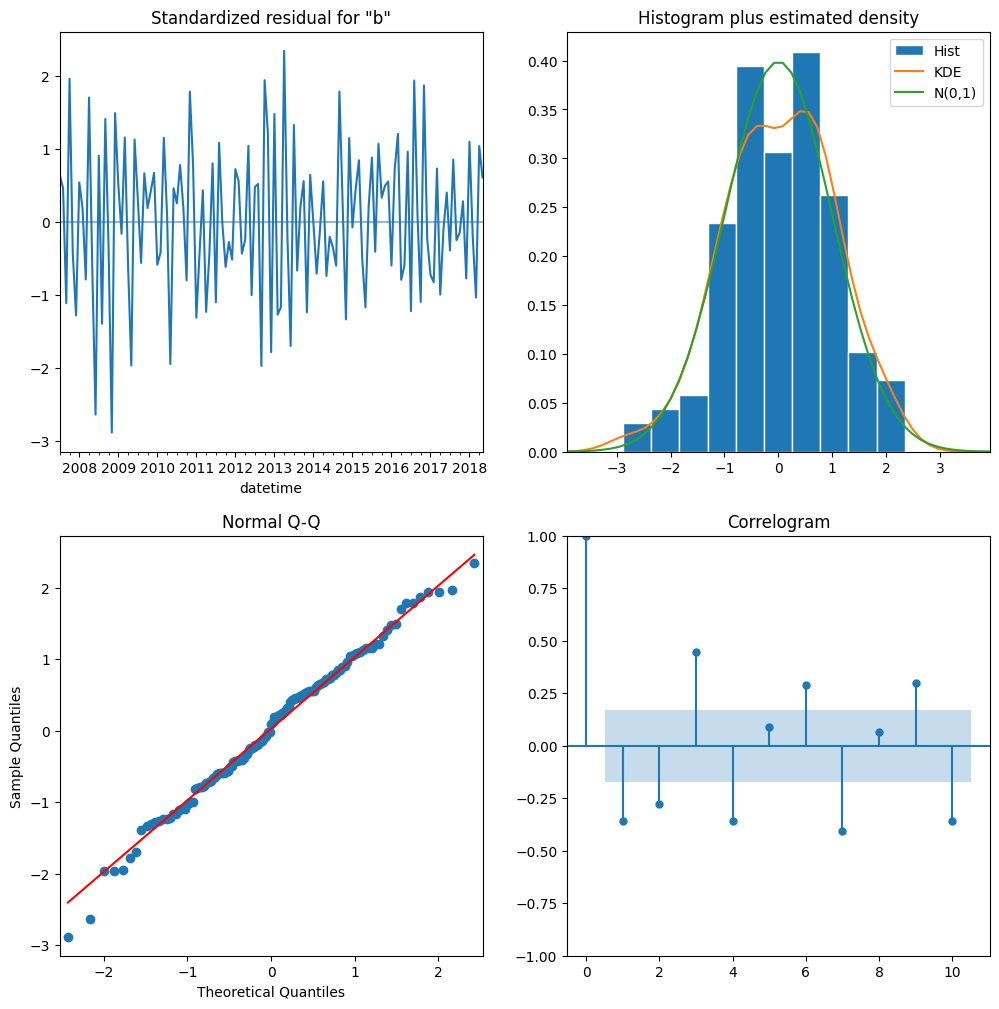

In [251]:
ordp, ordq, seap, seasd, seasq, method = (1, 1, 1, 1, 1, 'powell')
ordd = 2
s = 12

# Model without meat
base_model = forecast_sarimax(endog=y, exog=None, ordp=ordp,
                              ordq=ordq, ordd=ordd,
                              seasp=seap, seasd=seasd,
                              seasq=seasq, s=s, method=method)
print(base_model.plot_diagnostics(figsize=(12, 12)))

Get forecast with model

In [252]:
base_forecast_mean, base_forecast_conf = model_predict(model=base_model, exog=None, month_gap=month_gap)

Plot data

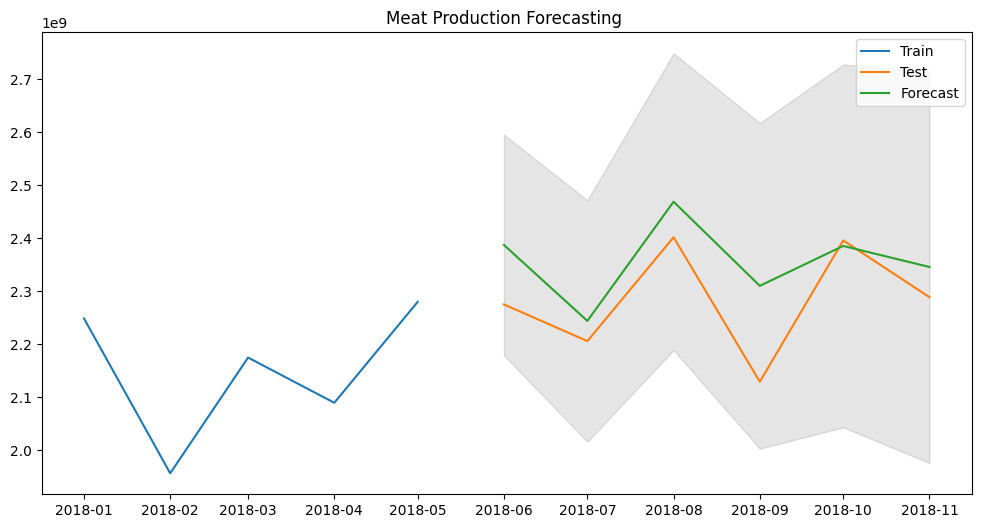

In [253]:
plot_pred_test(mean=base_forecast_mean, conf=base_forecast_conf,
               train_df=train_df, test_df=test_df, with_title='')

Calculate MAE

In [254]:
mae(base_forecast_mean, test_df[SUBJECT2])

2356746314.5838904

Do the same as above but with actual meat data as exog

Figure(1200x1200)


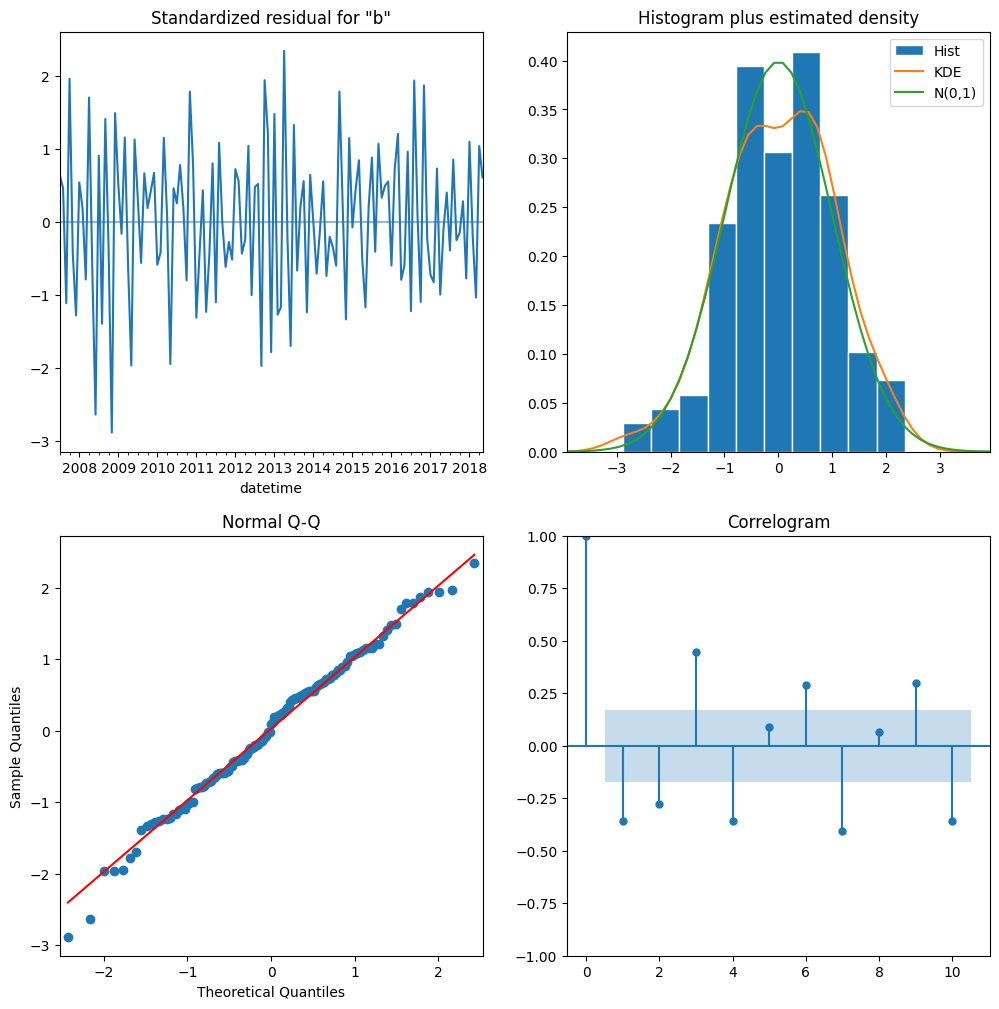

In [255]:
ordp, ordq, seap, seasd, seasq, method = (1, 1, 1, 0, 2, 'lbfgs')
ordd = 2
s = 12

model_with_actual_meat = forecast_sarimax(endog=y, exog=x, ordp=ordp,
                              ordq=ordq, ordd=ordd,
                              seasp=seap, seasd=seasd,
                              seasq=seasq, s=s, method=method)
print(base_model.plot_diagnostics(figsize=(12, 12)))

In [256]:
actual_meat_forecast_mean, actual_meat_forecast_conf = model_predict(model=model_with_actual_meat, exog=test_df[SUBJECT2], month_gap=month_gap)

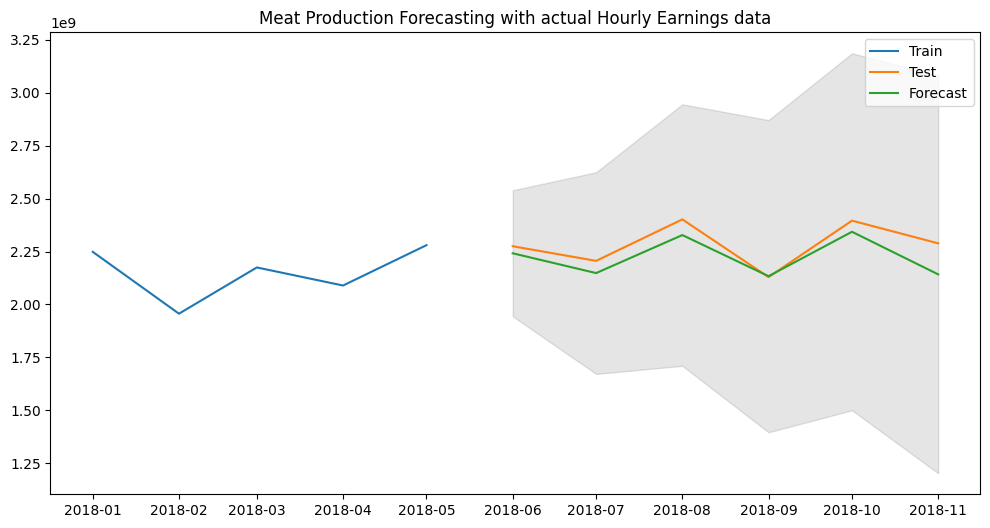

In [257]:
plot_pred_test(mean=actual_meat_forecast_mean, conf=actual_meat_forecast_conf,
               train_df=train_df, test_df=test_df, with_title=f'with actual {SUBJECT_TITLE2} data')

In [258]:
mae(actual_meat_forecast_mean, test_df[MEAT_CHOICE])

61409637.37317467

Do the same but with predicted meat data as exog

/home/lehoa/src/citadel-datathon/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Figure(1200x1200)


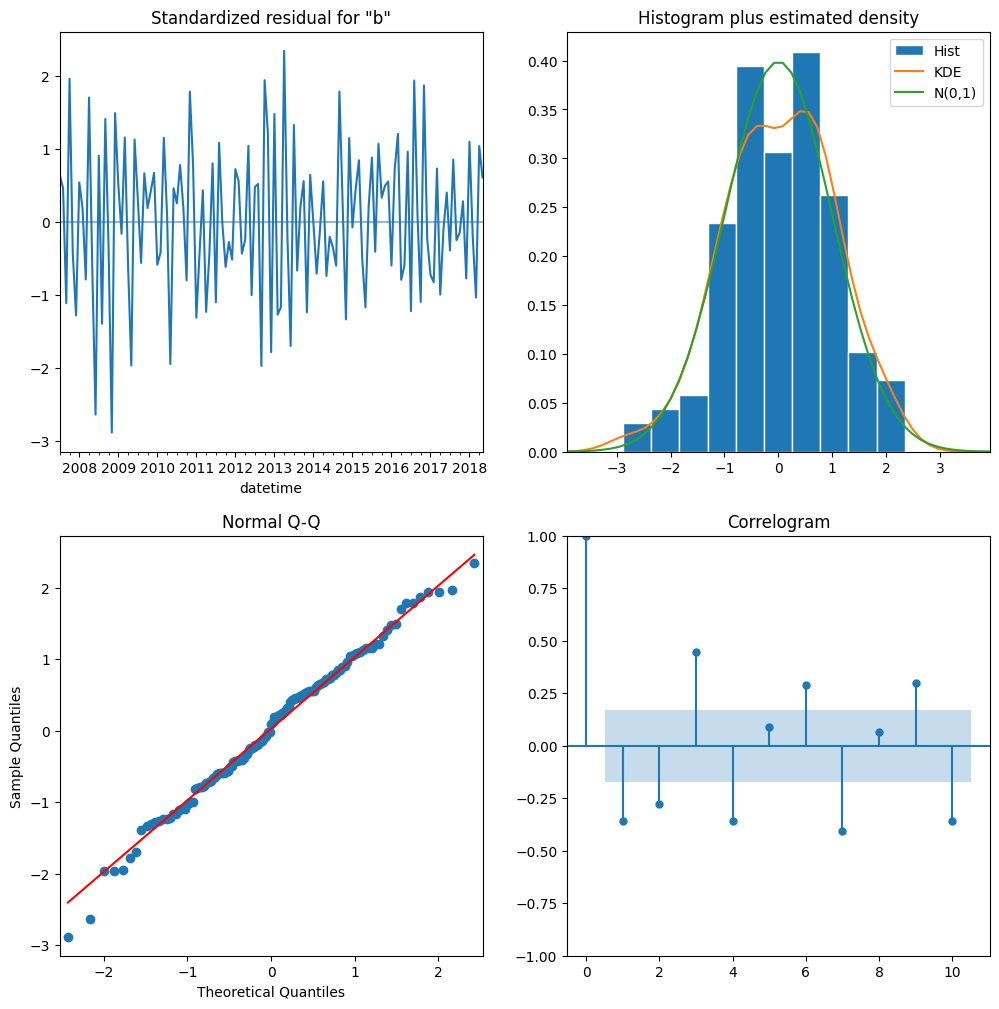

In [259]:
ordp, ordq, seap, seasd, seasq, method = (1, 1, 1, 1, 1, 'lbfgs')
ordd = 2
s = 12

model_with_predicted_meat = forecast_sarimax(endog=y, exog=x, ordp=ordp,
                              ordq=ordq, ordd=ordd,
                              seasp=seap, seasd=seasd,
                              seasq=seasq, s=s, method=method)
print(base_model.plot_diagnostics(figsize=(12, 12)))

In [260]:
PATH = '../model/sarimax_wage_forecasting.pkl'
with open(PATH, 'rb') as file:
    sarimax_wage = pickle.load(file)
pred_wage = sarimax_wage.get_forecast(steps=8)
pred_ware_diff = pred_wage.predicted_mean.diff().diff()
pred_ware_diff = pred_ware_diff.dropna()
pred_ware_diff

2018-08-01   -0.495467
2018-09-01    0.436446
2018-10-01   -0.119406
2018-11-01   -0.301510
2018-12-01    0.252994
2019-01-01    0.169433
Freq: MS, Name: predicted_mean, dtype: float64

In [261]:
pred_meat_forecast_mean, pred_meat_forecast_conf = model_predict(model=model_with_predicted_meat, exog=pred_ware_diff, month_gap=month_gap)

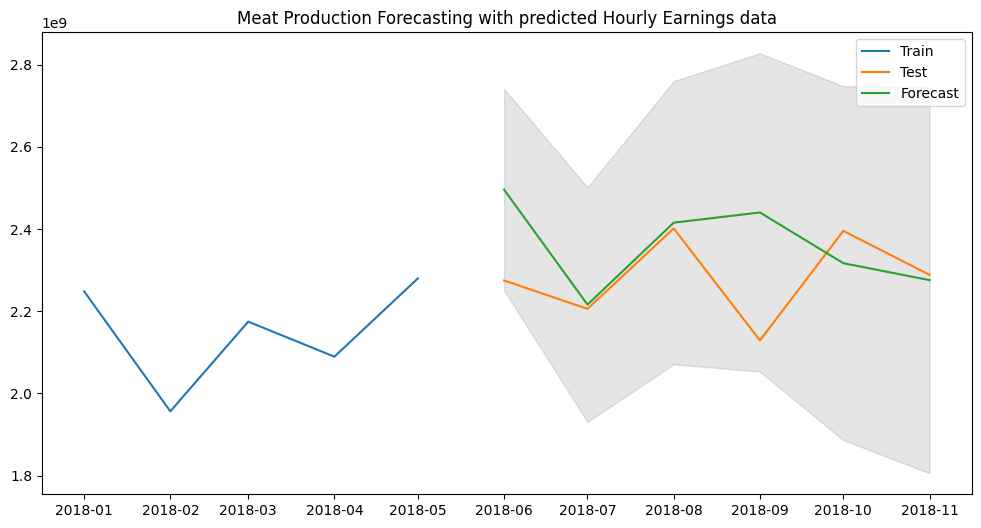

In [262]:
plot_pred_test(mean=pred_meat_forecast_mean, conf=pred_meat_forecast_conf,
               train_df=train_df, test_df=test_df, with_title=f'with predicted {SUBJECT_TITLE2} data')

In [263]:
mae(pred_meat_forecast_mean, test_df[MEAT_CHOICE])

108089825.43243861

In [264]:
LEARN_TO_YEAR = 2018
LEARN_FROM = date(1900, 1, 1)
LEARN_TO = date(LEARN_TO_YEAR, 1, 1)
train_df = merged_df[(merged_df['datetime'].dt.date >= LEARN_FROM) & (merged_df['datetime'].dt.date < LEARN_TO)]
train_df = train_df.set_index('datetime')
train_df = train_df.asfreq('MS')

In [265]:
TEST_FROM = date(2018, 1, 1)
TEST_TO = date(2018, 7, 1)
test_df = merged_df[(merged_df['datetime'].dt.date >= TEST_FROM) & (merged_df['datetime'].dt.date < TEST_TO)]
test_df = test_df.set_index('datetime')
test_df = test_df.asfreq('MS')

In [266]:
month_gap = (TEST_FROM.year - LEARN_TO.year) * 12 + (TEST_FROM.month - LEARN_TO.month)

Variables of choice to train on

In [267]:
x = train_df[SUBJECT2]
MEAT_CHOICE = 'beef'
y = train_df[MEAT_CHOICE]

Do grid-seach to find best MAE

In [268]:
def grid_search(endog, exog, test_endog, test_exog, search_depth=3):
    param_grid = {
        'ord_p': range(0, search_depth),
        'ord_q': range(0, search_depth),
        'season_p': range(0, search_depth),
        'season_d': range(0, search_depth),
        'season_q': range(0, search_depth),
        'opt': ['lbfgs', 'nm', 'powell']
    }
    parameter_combinations = list(product(*param_grid.values()))
    best_params = None
    best_mae = float('inf')
    for param in parameter_combinations:
        model_fit = forecast_sarimax(endog, exog, param[0], 2, param[1], param[2], param[3], param[4], 12, param[5])
        predict_mean, _ = model_predict(model_fit, test_exog, month_gap)
        cur_mae = mae(predict_mean, test_endog)
        if cur_mae < best_mae:
            best_mae = cur_mae
            best_params = param
            print(f'Best MAE: {best_mae}, best params: {best_params} so far')

    return (best_params, best_mae)

# best_param, best_mae = grid_search(endog=train_df[MEAT_CHOICE],
#                                    exog=train_df[SUBJECT2],
#                                    test_exog=test_df[SUBJECT2],
#                                    test_endog=test_df[MEAT_CHOICE],
#                                    search_depth=3)
print(best_param, best_mae)

(1, 1, 1, 0, 2, 'lbfgs') 57150809.943890415
